### Description
This document gives an initial data analysis to poweroffevent. There are four models used: kNN, SVM, Random Forest, and PCA

In [1]:
import pandas as pd
import numpy as np
import mglearn

In [24]:
df = pd.read_pickle('../data/wss_manufacturer_classify')

In [25]:
df = df[(df['itapudid']!='164950006001DC92C4708')&(df['itapudid']!='164950052001DC92C84A9')&(df['itapudid']!='164730014001DC924DA0D')&(df['itapudid']!='164950018001DC92C87EE')]

In [26]:
# The following steps are to prepare the data for modeling. They transform the dataframe to arrays.
df = df.reset_index(drop=True)
df = df[['mean', 'std','max','na_value_ratio', 'manufacturer']]
for i in range(135):
    df.set_value(i,'manufacturer', 1 if df.get_value(i,'manufacturer') == 'Knorr Bremse' else 0)
df_X = df[[ 'mean', 'std','max','na_value_ratio']]
df_y = df['manufacturer']
X = df_X.values
y = df_y.values
y = y.astype(np.int64)

In [6]:
import matplotlib.pyplot as plt

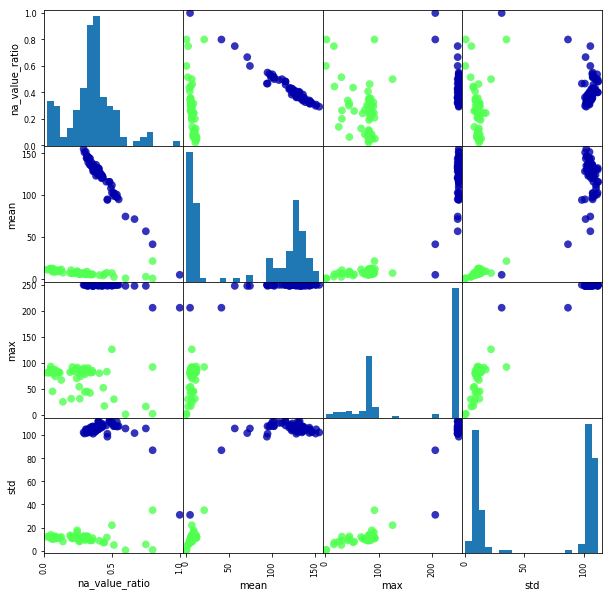

In [5]:
sm = pd.plotting.scatter_matrix(df_X, c = y, figsize = (10, 10),
                      marker = 'o', hist_kwds = {'bins': 20}, s =60,
                      alpha = .8, cmap = mglearn.cm3)
plt.show()

### Bulid kNN Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(X_train, y_train)

In [53]:
print('Test set accuracy: %.2f' % clf.score(X_test, y_test))

Test set accuracy: 1.00


In [27]:
X_1 = X[:,0:2]

In [30]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_1, y)
    mglearn.plots.plot_2d_separator(clf, X_1, fill = True, eps = 0.5, ax = ax, alpha = .4)
    mglearn.discrete_scatter(X_1[:, 0], X_1[:, 1], y, ax = ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel('mean')
    ax.set_ylabel('std')
_ = axes[0].legend(loc = 3)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors = 1)
score = cross_val_score(clf, X_1, y, cv=3, scoring='roc_auc').mean()
print(score)

1.0


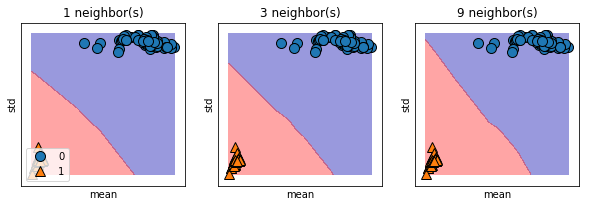

In [31]:
plt.show()

### Bulid SVM Model

In [37]:
from sklearn.svm import SVC

def plot_svm(clf):
    mglearn.plots.plot_2d_separator(clf, X_1, eps = .5)
    mglearn.discrete_scatter(X_1[:,0], X_1[:,1], y)
    sv = clf.support_vectors_
    sv_labels = clf.dual_coef_.ravel() > 0
    mglearn.discrete_scatter(sv[:,0], sv[:, 1], sv_labels, s = 15, markeredgewidth = 3)
    plt.ylabel('Feature 1')
    plt.xlabel('Feature 0')
     
    

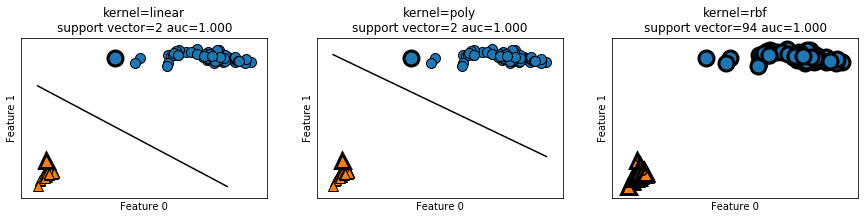

In [38]:
plt.figure(figsize=(15, 10))
num = 1
for kernel in ['linear','poly','rbf']:
    clf = SVC(kernel=kernel)
    clf.fit(X_1, y)
    score = cross_val_score(clf, X_1, y, cv=10, scoring='roc_auc').mean()
    plt.subplot(3, 3, num);
    plt.title('kernel=%s\nsupport vector=%d auc=%.3f' % (
        kernel, clf.support_vectors_.shape[0], score))
    plot_svm(clf)
    num += 1        
plt.show();

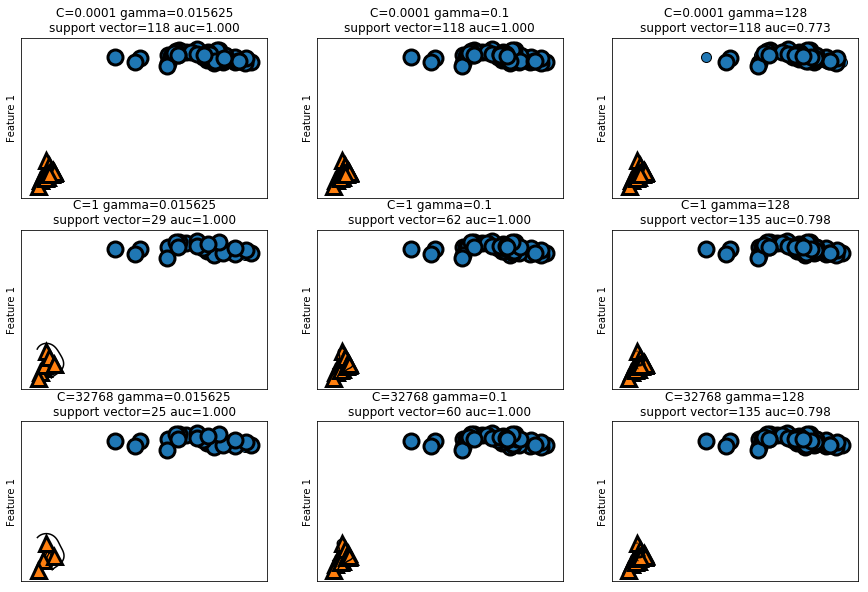

In [34]:
plt.figure(figsize=(15, 10));
num = 1
for c in [0.0001, 1, 32768]:
    for gamma in [0.015625, 0.1, 128]:
        clf = SVC(kernel='rbf', C=c, gamma=gamma)
        clf.fit(X_1, y)
        score = cross_val_score(clf, X_1, y, cv=10, scoring='roc_auc').mean()
        plt.subplot(3, 3, num);
        plt.title('C=%s gamma=%s\nsupport vector=%d auc=%.3f' % (
            c, gamma, clf.support_vectors_.shape[0], score))
        plot_svm(clf)
        num += 1        
plt.show();

In [78]:
# Get the predictors X and the labels y 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, stratify = y, random_state=0)

k = [2**x for x in range(-15, 16)]
param_grids = [
        {'kernel': ['linear'], 'C': k},
        {'kernel': ['poly'], 'C': k, 'degree': range(1, 11)},
        {'kernel': ['rbf'], 'C': k, 'gamma': k}]
best_score = 0
best_params = None
for param in param_grids:
    rs = RandomizedSearchCV(SVC(), param_distributions=param, n_iter = 10, n_jobs=-1)
    rs.fit(X_train, y_train)
    if rs.best_score_ > best_score:
        best_score = rs.best_score_
        best_params = rs.best_params_
        best_estimator = rs.best_estimator_
print('Best AUC score: {:.3f} with params: {}'.format(best_score, best_params))

Best AUC score: 1.000 with params: {'kernel': 'linear', 'C': 16384}


### Build RandomForest Model

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

param_grid = {
    'max_features': range(1,X.shape[1] + 1),
    'n_estimators': [1,2,4,8,16,32,64,128]    
}

rf = RandomForestClassifier()

grid = GridSearchCV(rf, param_grid = param_grid)
scores = cross_val_score(grid, X, y, scoring="roc_auc")
print("Best cross-validation score (AUC): {:.3f}".format(scores.max()))

grid1 = GridSearchCV(rf, param_grid=param_grid, scoring="roc_auc")
grid1.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid1.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid1.best_score_))


Best cross-validation score (AUC): 1.000

Grid-Search with AUC
Best parameters: {'max_features': 1, 'n_estimators': 8}
Best cross-validation score (AUC): 1.000


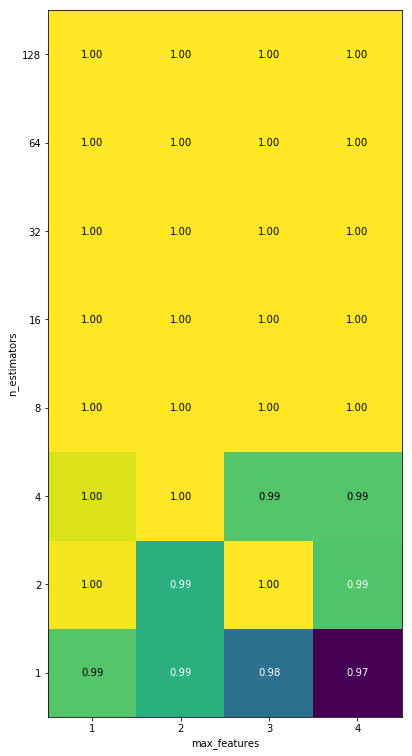

In [86]:
from matplotlib.collections import PolyCollection

results = pd.DataFrame(grid1.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['max_features']), len(param_grid['n_estimators'])).T
# plot the mean cross-validation scores
plt.figure(figsize = (13,13))
mglearn.tools.heatmap(scores, xlabel='max_features', xticklabels=param_grid['max_features'],
                      ylabel='n_estimators', yticklabels=param_grid['n_estimators'], cmap="viridis")
plt.show()

### Bulid PCA Model

[ 0.98354081  0.01394876]


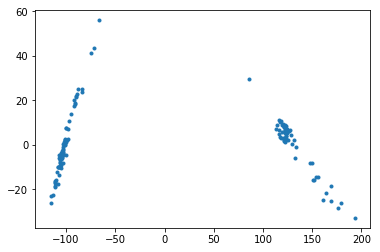

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,svd_solver='full')
pca.fit(X)
print(pca.explained_variance_ratio_)
pcaf = pca.fit_transform(X)
plt.scatter(*pcaf.T, marker='.')
plt.show()